In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import os
import sklearn as sk
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from imutils import paths
from skimage import io
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
import tensorflow.keras.optimizers as optim
from tensorflow.keras import preprocessing as pp
from tensorflow.keras import callbacks as cb
import matplotlib.pyplot as plt
import pandas as pd
tf.__version__

'2.3.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Processamento das imagens usando Keras image preprocessing

Tive que mudar muita coisa para usar modelos pre-treinados,
como nao consegui usar as imagens direto, tive que refazer
o processamento de imagens. 

In [3]:
batch_size = 32
img_size = 256
seed=42
root_dir = "C:/Users/Cafalchio/Documents/pelagem_gatos/imagens"

In [4]:
train_datagen = pp.image.ImageDataGenerator(rescale=1./255.,
                                            validation_split=0.2,
                                            featurewise_std_normalization=False,
                                            rotation_range=30,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True,
                                            vertical_flip=False
                                            )

valid_datagen = pp.image.ImageDataGenerator(rescale=1./255, 
                                            validation_split=0.2,
                                            featurewise_std_normalization=False)



valid_gen = valid_datagen.flow_from_directory(root_dir, subset='validation',\
                                              shuffle=True, seed=42, 
                                              target_size=(256,256),\
                                              batch_size=batch_size)

train_gen = train_datagen.flow_from_directory(root_dir, subset='training',\
                          shuffle=True, seed=42, target_size=(256,256),\
                          batch_size=batch_size)

    

Found 137 images belonging to 9 classes.
Found 568 images belonging to 9 classes.


**Mostra as imagens**

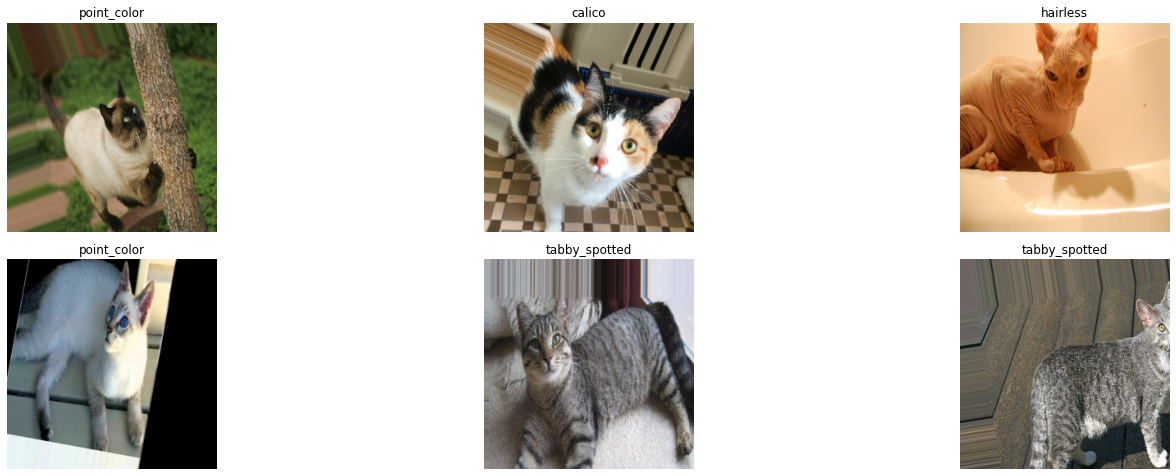

In [5]:
def decode(label): #Funcao para decodificar os labels (depois checa se os gatos estao com o label certo)
    nomes = ['bicolor',
             'calico',
             'hairless',
             'point_color',
             'solid_color',
             'tabby_classic',
             'tabby_mackerel',
             'tabby_spotted',
             'tortoiseshell']
    return nomes[np.argmax(label)]

# mostrar as imagens, tambem adaptado do codigo acima
def show_batch(images_, labels_):
    plt.figure(figsize=(20,10))
    for n in range(6):
        label = [x for x in labels_]
        image = [x for x in images_]
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image[n])
        plt.title(decode(label[n]))
        plt.axis('off')
        plt.tight_layout()
images_, labels_ = next(train_gen)
show_batch(images_, labels_)

### Modelos ja treinados para imagenet
* https://keras.io/api/applications/
* MobileNetV2 e' menor e por isso ocupa menos espaco na memoria do celular

In [13]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=True,
                                        weights="imagenet",
                                        input_shape = (224,224,3)
                                        )
resnet50 = tf.keras.applications.ResNet50(include_top=True,
                            weights="imagenet",
                            input_shape = (224,224,3) #Usei o mesmo tamanho
                            ) 
efficientB3 = tf.keras.applications.EfficientNetB3(include_top=False,
                            weights="imagenet",
                            input_shape = (224,224,3) #Usei o mesmo tamanho
                            ) 


In [15]:
 def cria_modelo(modelo = efficientB3):
    model = tf.keras.Sequential()
    model.add(modelo)
    model.add(tf.keras.layers.Dense(1000,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(9,activation='sigmoid'))
    
    return model

In [16]:
#cria o modelo, pode testar modelos diferentes da list do keras
model = cria_modelo(modelo = mobilenet)

## Treinamento
Como esses modelos ja sao pre-treinados, o melhor jeito e' treinar primeiro os layers que foram adicionados e depois treinar tudo com um learning rate bem pequeno.

O que fazer para melhorar.
* Tentar usar (freeze) no modelo e treinar so as novas camadas com lr alto, depois treinar tudo com lr baixo
* Mais imagens
* Checar se nao tem imagens repetidas ou imgens em classes erradas
* Usar Callback para salvar o melhor modelo antes do overfiting
* Tentar algumas imagens para test
* Efficient Nets sao de B0 - B7, dependendo da memoria, vai ter que usar uma rede menor


In [17]:
def train_model(lr, epochs, batch_size=32):
    
    opt = optim.Adam(learning_rate=lr, name='Adam')
    reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=lr)

    model.compile(loss='categorical_crossentropy' ,
                  optimizer=opt, metrics=['AUC', 'CategoricalAccuracy', 'FalseNegatives', 'FalsePositives'])
    
    with tf.device('/GPU:0'):
        history=model.fit(
                train_gen,
                steps_per_epoch= train_gen.samples // batch_size,
                epochs=epochs,
                validation_data= valid_gen,
                validation_steps= valid_gen.samples// batch_size, 
                callbacks=[reduce_lr] 
                        
                )
    return history

In [18]:
history = train_model(lr=1e-4, epochs = 18) 

C:\Users\Cafalchio\anaconda3\envs\gatos\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/18
17/17 [==============================] - 14s 813ms/step - loss: 2.1958 - auc: 0.5535 - categorical_accuracy: 0.2164 - false_negatives: 240.0000 - false_positives: 1836.0000 - val_loss: 2.1928 - val_auc: 0.6289 - val_categorical_accuracy: 0.2344 - val_false_negatives: 49.0000 - val_false_positives: 403.0000
Epoch 2/18
17/17 [==============================] - 13s 754ms/step - loss: 2.1885 - auc: 0.6720 - categorical_accuracy: 0.2593 - false_negatives: 184.0000 - false_positives: 1645.0000 - val_loss: 2.1796 - val_auc: 0.7204 - val_categorical_accuracy: 0.2500 - val_false_negatives: 36.0000 - val_false_positives: 345.0000
Epoch 3/18
17/17 [==============================] - 13s 769ms/step - loss: 2.1652 - auc: 0.7348 - categorical_accuracy: 0.2910 - false_negatives: 161.0000 - false_positives: 1581.0000 - val_loss: 2.1524 - val_auc: 0.7659 - val_categorical_accuracy: 0.3047 - val_false_negatives: 36.0000 - val_false_positives: 281.0000
Epoch 4/18
17/17 [=========================

In [21]:
model.save_weights("efficientnet_b3.h5")
print("Saved model to disk")

Saved model to disk


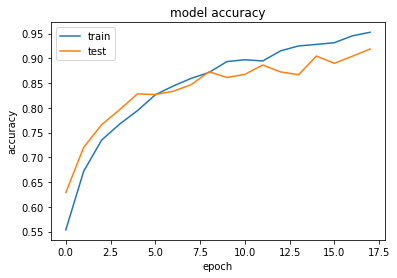

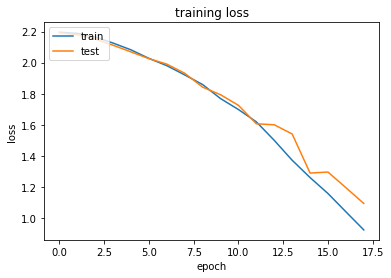

In [19]:
# plt acuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

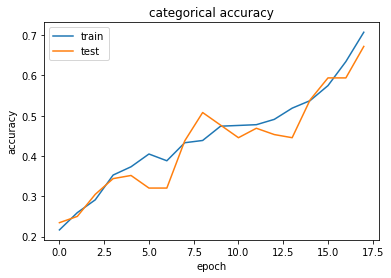

In [20]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()